# MSD vectorization

This notebook tries to vectorize the MSD calculation from Cristian, to speed up the analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import pandas as pd
from numba import jit, cuda

## 1 load trajectory data

In [11]:
# load a trajectory
traj_r = pd.read_csv('/home/zhengyang/Dropbox/Fluctuation Bacterial Droplets/Data/exp1.csv', names=['x', 'y', 'z'])
traj = np.array(traj_r)
# traj = np.random.rand(2000, 3)

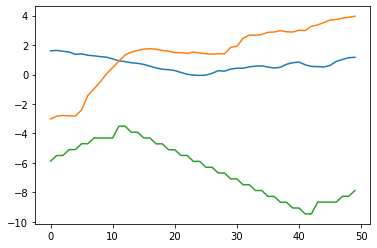

In [3]:
plt.plot(traj[:50, 0])
plt.plot(traj[:50, 1])
plt.plot(traj[:50, 2])

In [2]:
%%time
n = int(2e7)
traj = pd.DataFrame({'x': np.random.rand(n), 'y': np.random.rand(n), 'z':np.random.rand(n), 'frame': np.arange(n), 'particle': np.zeros(n)})

CPU times: user 1.29 s, sys: 953 ms, total: 2.24 s
Wall time: 2.26 s


In [14]:
%%time
msd = tp.msd(traj, mpp=1, fps=1, pos_columns=['x', 'y', 'z'], max_lagtime=len(traj))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## 2 Trackpy.msd

In [12]:
%%time
## trackpy
t = traj_r.assign(particle=0, frame=traj_r.index)
msd = tp.msd(t, mpp=1, fps=1, pos_columns=['x', 'y', 'z'], max_lagtime=len(t))

CPU times: user 79.9 ms, sys: 16 ms, total: 95.9 ms
Wall time: 93.3 ms


**Comments:** `trackpy` uses an FFT algorithm to compute MSD which makes it fast than the gap algorithm by definition. The algorithm is described in [this paper](https://www.neutron-sciences.org/articles/sfn/pdf/2011/01/sfn201112010.pdf).

## 3 Nested for loops

In [24]:
def nested_loop_msd(traj):
    msd_x = []
    msd_y = []
    msd_z = []
    for i in range(0, len(traj[:, 0])):
        sum_x = 0
        sum_y = 0
        sum_z = 0
        n = len(traj[:, 0]) - i
        for j in range(0, n):
            sum_x += (traj[i+j, 0] - traj[j, 0]) ** 2
            sum_y += (traj[i+j, 1] - traj[j, 1]) ** 2
            sum_z += (traj[i+j, 2] - traj[j, 2]) ** 2
#         msd_x.append(sum_x/n)
#         msd_y.append(sum_y/n)
#         msd_z.append(sum_z/n)
    return (msd_x, msd_y, msd_z)

In [14]:
@jit(target="cpu")
def nested_loop_msd_gpu(traj):
    msd_x = []
    msd_y = []
    msd_z = []
    for i in range(0, len(traj[:, 0])):
        sum_x = 0
        sum_y = 0
        sum_z = 0
        n = len(traj[:, 0]) - i
        for j in range(0, n):
            sum_x += (traj[i+j, 0] - traj[j, 0]) ** 2
            sum_y += (traj[i+j, 1] - traj[j, 1]) ** 2
            sum_z += (traj[i+j, 2] - traj[j, 2]) ** 2
        msd_x.append(sum_x/n)
        msd_y.append(sum_y/n)
        msd_z.append(sum_z/n)
    return (msd_x, msd_y, msd_z)

In [25]:
%%time
a = nested_loop_msd(traj[:2000])

CPU times: user 6.63 s, sys: 7.34 ms, total: 6.64 s
Wall time: 6.67 s


In [28]:
%%time
a = nested_loop_msd_gpu(traj)

CPU times: user 1.6 s, sys: 56.2 ms, total: 1.66 s
Wall time: 1.65 s


In [5]:
%%time 
## brutal method
msd_x = []
msd_y = []
msd_z = []
for i in range(0, len(traj[:, 0])):
    sum_x = 0
    sum_y = 0
    sum_z = 0
    n = len(traj[:, 0]) - i
    for j in range(0, n):
        sum_x += (traj[i+j, 0] - traj[j, 0]) ** 2
        sum_y += (traj[i+j, 1] - traj[j, 1]) ** 2
        sum_z += (traj[i+j, 2] - traj[j, 2]) ** 2
    msd_x.append(sum_x/n)
    msd_y.append(sum_y/n)
    msd_z.append(sum_z/n)

CPU times: user 10min 22s, sys: 9.56 ms, total: 10min 22s
Wall time: 10min 23s


## 4 Vectorized

In [7]:
def vectorized_msd(traj):
    ## vectorized code
    msd_list = []
    for i in range(0, len(traj[:, 0])):
        shifted = np.roll(traj, i, axis=0)
        shifted[:i, :] = np.nan
        diff = traj - shifted
        diff_msq = np.nanmean((diff ** 2), axis=0)
        msd_list.append(diff_msq)
    return np.array(msd_list)

In [8]:
@jit(target="cpu")
def vectorized_msd_gpu(traj):
    ## vectorized code
    msd_list = []
    for i in range(0, len(traj[:, 0])):
        shifted = np.roll(traj, i, axis=0)
        shifted[:i, :] = np.nan
        diff = traj - shifted
        diff_msq = np.nanmean((diff ** 2), axis=0)
        msd_list.append(diff_msq)
    return np.array(msd_list)

In [10]:
%%time
a = vectorized_msd(traj[:2000])

TypeError: '(slice(None, None, None), 0)' is an invalid key

In [9]:
%%time
a = vectorized_msd_gpu(traj[:2000])

/tmp/ipykernel_146772/3551173925.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "vectorized_msd_gpu" failed type inference due to: non-precise type pyobject
During: typing of argument at /tmp/ipykernel_146772/3551173925.py (4)

File "../../../../../../../tmp/ipykernel_146772/3551173925.py", line 4:
<source missing, REPL/exec in use?>

  @jit(target="cpu")
/tmp/ipykernel_146772/3551173925.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "vectorized_msd_gpu" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../../../../tmp/ipykernel_146772/3551173925.py", line 5:
<source missing, REPL/exec in use?>

  @jit(target="cpu")
/home/zhengyang/miniconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "vectorized_msd_gpu" was compiled in object mode without forceobj=Tru

TypeError: '(slice(None, None, None), 0)' is an invalid key

[]

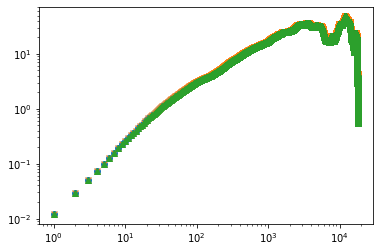

In [115]:
plt.plot(msd_x, marker='o', ls='')
plt.plot(msd['<x^2>'], marker='x', ls='')
plt.plot(msd_a[:, 0], marker='^', ls='')
plt.loglog()

```matlab
function [MSD_X,MSD_Y,MSD_Z,MSD,t_MSD] = msd_Gotaxyz(xc,yc,zc,fps)

X = xc;
Y = yc;
Z=zc;
%   MSD_X =zeros(1,length(X)/10);
%   MSD_Y = zeros(1,length(X)/10);
%   MSD_Z = zeros(1,length(X)/10);
%   MSD=zeros(1,length(X)/10);
for i = 1: length(X)/10%length(X)-1 % Recorro desde el primero hasta el penúltimo, para tener una diferencia. (Último con último == 0)  Para grabaciones cerca dejar en length(X)/10

    Suma_X = 0;
    Suma_Y = 0;
    Suma_Z=0;
    for j = 1:length(X)-i % Me voy separando de l en l. Si estoy parado en el elemento i, la máxima separación que me lleva al último elemento es length(X)-i
    
        Suma_X = Suma_X + (X(i+j) -X(j))^2; 
        Suma_Y = Suma_Y + (Y(i+j) -Y(j))^2; 
        Suma_Z = Suma_Z + (Z(i+j) -Z(j))^2; 

    end
    
    MSD_X(i) = Suma_X/(length(X)-i);
    MSD_Y(i) = Suma_Y/(length(X)-i);
    MSD_Z(i) = Suma_Z/(length(X)-i);

    MSD(i) = (Suma_X+Suma_Y+Suma_Z)/(length(X)-i);
    
end

% Para analisis gotas cerca volver a ponerlo
 MSD_X = [0,MSD_X] ;
 MSD_Y = [0,MSD_Y];
 MSD_Z=[0,MSD_Z];
 MSD = [0,MSD];

if length(fps) == 1

%linspace(0,length(X),length(X))/fps;
%t_MSD=(0:length(MSD)-1)/fps;
t_MSD=(0:length(MSD)-1)/fps;

else
    
%t_MSD=(0:length(MSD)-1)/mean(fps);
t_MSD=(0:length(MSD)-1)/mean(fps);
    
end


```